<h1>Содержание<span class="tocSkip"></span></h1>
</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загружаем библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
from sklearn.metrics import mean_squared_error as mse
warnings.filterwarnings('ignore')
pt = PowerTransformer()

Рассматриваем данные

In [2]:
df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Наши данные с периодичностью 10 минут.
Нам необходимо перевести в почасой формат.

In [4]:
df_resample = df.resample("1H").sum()
df_resample.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Визуализируем данные

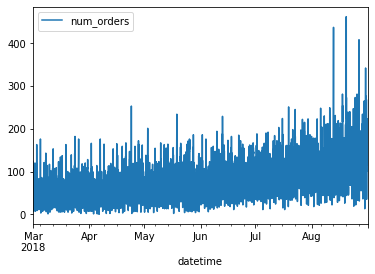

In [5]:
df_resample.plot()
plt.show()

Видим тенденцию к повышению объёма заказов.

## Анализ

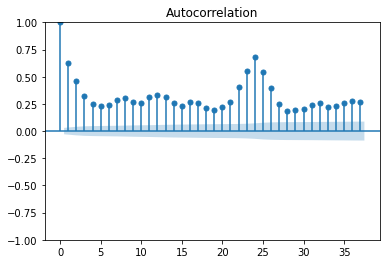

In [6]:
plot_acf(df_resample)
plt.show()

In [7]:
adfuller(df_resample["num_orders"])

(-3.0689242890279558,
 0.028940051402612906,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

Критическое значение = -3.06 < -2.86 прие 5-% доверительном интервале. Следовательно, ряд можно считать стационарным. Однако с виду на графике есть сезонность.

In [8]:
df_resample.index[:30]

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               '2018-03-01 10:00:00', '2018-03-01 11:00:00',
               '2018-03-01 12:00:00', '2018-03-01 13:00:00',
               '2018-03-01 14:00:00', '2018-03-01 15:00:00',
               '2018-03-01 16:00:00', '2018-03-01 17:00:00',
               '2018-03-01 18:00:00', '2018-03-01 19:00:00',
               '2018-03-01 20:00:00', '2018-03-01 21:00:00',
               '2018-03-01 22:00:00', '2018-03-01 23:00:00',
               '2018-03-02 00:00:00', '2018-03-02 01:00:00',
               '2018-03-02 02:00:00', '2018-03-02 03:00:00',
               '2018-03-02 04:00:00', '2018-03-02 05:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H')

Прошу помочь с визуализацией третьего графика - не могу понять в чём проблема.

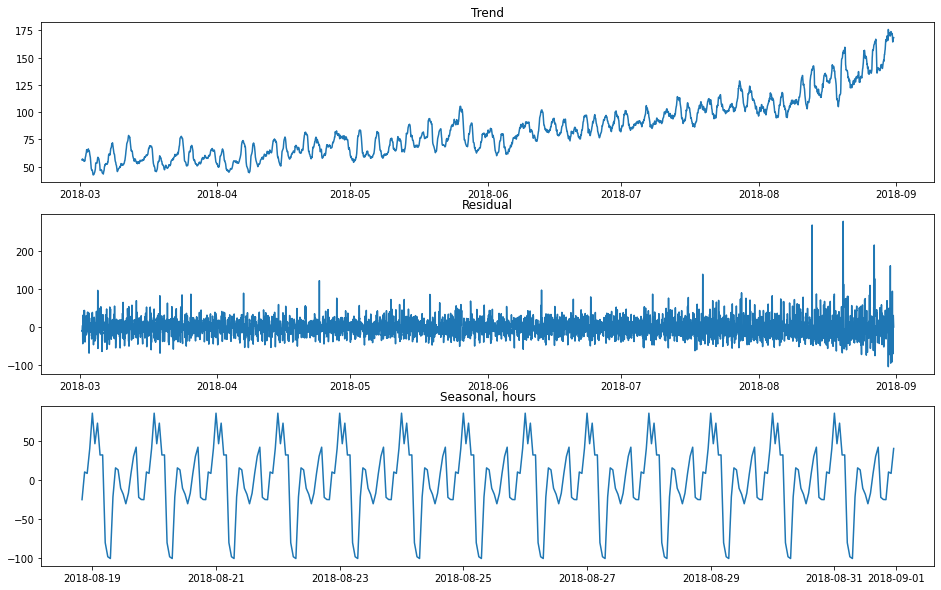

In [9]:
decomposed = seasonal_decompose(df_resample)
decomposed_short = seasonal_decompose(df_resample[4100:])

fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.resid)
axs[1].set_title("Residual")

#axs[2].plot(decomposed.seasonal['2018-03-01 01:00:00','2018-03-02 23:00:00'].plot(ax=plt.gca()))
axs[2].plot(decomposed_short.seasonal)
axs[2].set_title("Seasonal, hours")
#axs[2].set_xlim(('2018-03-01 00:00:00','2018-03-02 23:00:00'))
axs[2].set_xlim

plt.show()

**Выводы**:

    - 1) Мы видим чёткий восходящий тренд.
    
    - 2) Ближе к окночанию временного ряда видим участившиеся и услившиеся выбросы и волатильность.
    
    - 3) Мы видим чёткую цикличность.

## Обучение

создаём функции для удобства

In [10]:
def rmse(first_list, second_list):
    return np.sqrt(mse(first_list, second_list))
    
def make_features(data, max_lag, rolling_mean_size, differentiate=False):
    ARMA_df = data.copy(deep=True)
    ARMA_df['dayofweek'] = ARMA_df.index.dayofweek
    ARMA_df['hour'] = ARMA_df.index.hour
    for lag in range(1, max_lag + 1):
        ARMA_df['lag_{}'.format(lag)] = ARMA_df['num_orders'].shift(lag)
        
    ARMA_df['rolling_mean'] = ARMA_df['num_orders'].shift(lag).rolling(rolling_mean_size).mean()
    
    if differentiate:
       #ARMA_df["diff"] = ARMA_df['num_orders'] - ARMA_df["num_orders"].shift(1)
        ARMA_df["diff"] = ARMA_df['num_orders'].shift() - ARMA_df["num_orders"].shift(24) # in-day seasonal part
   
    return ARMA_df




Разбиваем данные

In [11]:
train, test = train_test_split(df_resample, shuffle=False, test_size=0.1)
train.dropna(inplace=True)

X_train = train.drop("num_orders", axis=1)
y_train = train["num_orders"]

X_test = test.drop("num_orders", axis=1)
y_test = test["num_orders"]

Predict with median(rmse): 87.15277582981295
Predict with mean(rmse): 84.74414402014742


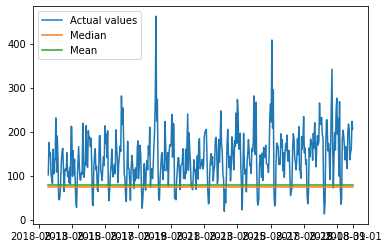

In [12]:
predictions_median = test.shape[0] * [train.median()]
predictions_mean = test.shape[0] * [train.mean()]

print("Predict with median(rmse):", rmse(y_test, predictions_median))
print("Predict with mean(rmse):", rmse(y_test, predictions_mean))

plt.plot(X_test.index, y_test, label='Actual values')
plt.plot(X_test.index, predictions_median, label='Median')
plt.plot(X_test.index, predictions_mean, label='Mean')

plt.legend()
plt.show()

In [13]:
best_rmse = 10**5
values = [i for i in range(1, 15)]
for p in values:
    for q in values:
        ARMA_df = make_features(df_resample, p, q, differentiate=True) # include derivative though the time series is stationary
        
        train, test = train_test_split(ARMA_df, shuffle=False, test_size=0.1)
        train.dropna(inplace=True)
        
        X_train = train.drop("num_orders", axis=1)
        y_train = train["num_orders"]

        X_test = test.drop("num_orders", axis=1)
        y_test = test["num_orders"]
        
        lin_reg = lr()
        lin_reg.fit(X_train, y_train)

        preds = lin_reg.predict(X_train)
        
        current_rmse = rmse(preds, y_train)
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_p = p
            best_q = q
print("RMSE:", best_rmse, "\nP:", best_p, "\nQ:", best_q)

RMSE: 26.419982360297336 
P: 14 
Q: 8


In [14]:
df_with_best_p_and_q = make_features(df_resample, best_p, best_q, differentiate=True)

train, test = train_test_split(df_with_best_p_and_q, shuffle=False, test_size=0.1)
train.dropna(inplace=True)

X_train = train.drop("num_orders", axis=1)
y_train = train["num_orders"]

X_test = test.drop("num_orders", axis=1)
y_test = test["num_orders"]

**Линейная регрессия**

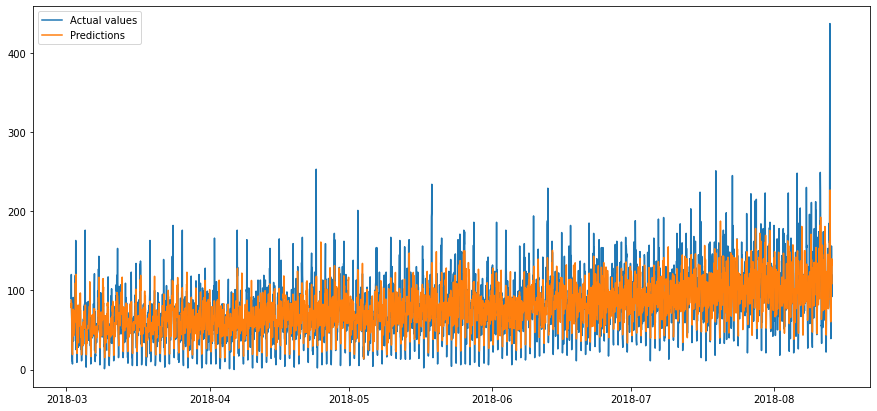

RMSE: 26.419982360297336
CPU times: user 265 ms, sys: 128 ms, total: 393 ms
Wall time: 406 ms


In [15]:
%%time

best_lin_reg = lr().fit(X_train, y_train)
best_predictions_train_lr = best_lin_reg.predict(X_train)
plt.figure(figsize=(15, 7))
plt.plot(X_train.index, y_train, label='Actual values')
plt.plot(X_train.index, best_predictions_train_lr, label='Predictions')
plt.legend()
plt.show()

print("RMSE:", rmse(best_predictions_train_lr, y_train))

**Регрессия Ridge**

Проведем кроссвалидацию для следующих моделей в два шага:

С помощью GridSearchCV найдем лучший параметр.
Используя cv_time_series_rmse получить результат кроссвалидации на временном ряду.

In [16]:
%%time

regressor = Ridge()
hyperparams_ridge = [{'alpha':[0.1, 1, 10, 100, 1000],
                'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
clf = GridSearchCV(regressor, hyperparams_ridge, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
best_params_Ridge = clf.best_params_
print(best_params_Ridge)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'alpha': 0.1, 'solver': 'sparse_cg'}

Grid scores on development set:

28.923477 for {'alpha': 0.1, 'solver': 'auto'}
28.923477 for {'alpha': 0.1, 'solver': 'svd'}
28.923477 for {'alpha': 0.1, 'solver': 'cholesky'}
28.927358 for {'alpha': 0.1, 'solver': 'lsqr'}
28.923393 for {'alpha': 0.1, 'solver': 'sparse_cg'}
28.923477 for {'alpha': 1, 'solver': 'auto'}
28.923477 for {'alpha': 1, 'solver': 'svd'}
28.923477 for {'alpha': 1, 'solver': 'cholesky'}
28.927360 for {'alpha': 1, 'solver': 'lsqr'}
28.923399 for {'alpha': 1, 'solver': 'sparse_cg'}
28.923485 for {'alpha': 10, 'solver': 'auto'}
28.923485 for {'alpha': 10, 'solver': 'svd'}
28.923485 for {'alpha': 10, 'solver': 'cholesky'}
28.927382 for {'alpha': 10, 'solver': 'lsqr'}
28.923401 for {'alpha': 10, 'solver': 'sparse_cg'}
28.923566 for {'alpha': 100, 'solver': 'auto'}
28.923566 for {'alpha': 100, 'solver': 'svd'}
28.923566 for {'alp

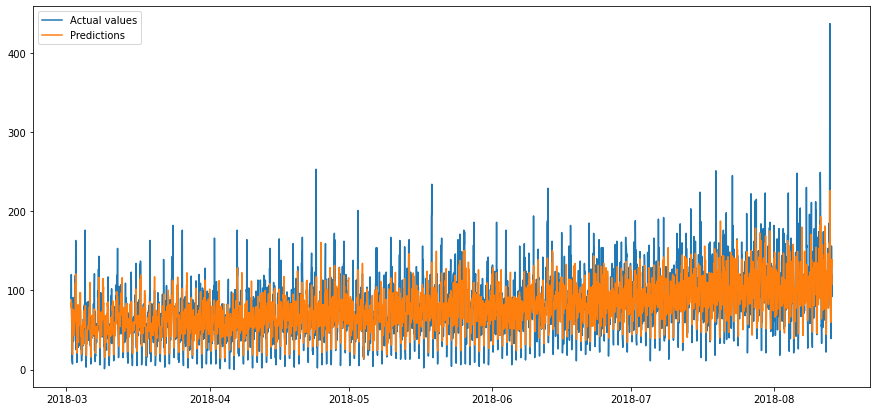

RMSE: 26.42556635989391


In [17]:
best_params_R = Ridge().set_params(**best_params_Ridge).fit(X_train, y_train)
best_predictions_train_ridge = best_params_R.predict(X_train)
plt.figure(figsize=(15, 7))
plt.plot(X_train.index, y_train, label='Actual values')
plt.plot(X_train.index, best_predictions_train_ridge, label='Predictions')
plt.legend()
plt.show()

print("RMSE:", rmse(best_predictions_train_ridge, y_train))

**Регрессия Lasso**

Проведем кроссвалидацию для следующих моделей в два шага:

С помощью GridSearchCV найдем лучший параметр.
Используя cv_time_series_rmse получить результат кроссвалидации на временном ряду.

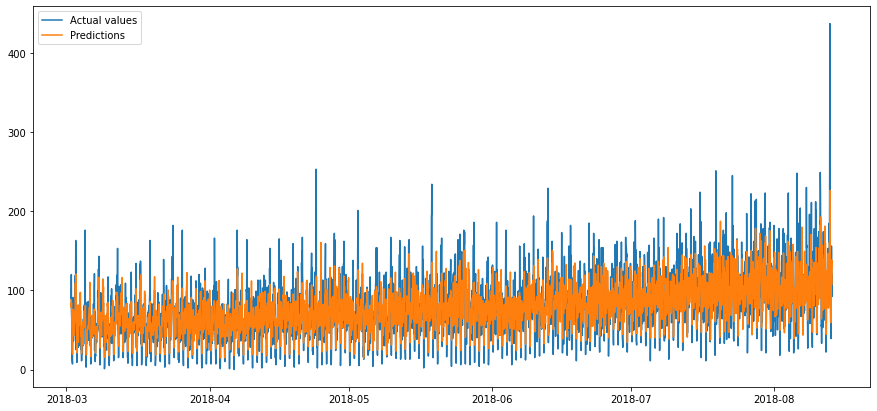

RMSE: 26.4258405175116
CPU times: user 270 ms, sys: 178 ms, total: 447 ms
Wall time: 457 ms


In [18]:
%%time

best_lin_lasso = Lasso().fit(X_train, y_train)
best_predictions_train_lasso = best_lin_lasso.predict(X_train)
plt.figure(figsize=(15, 7))
plt.plot(X_train.index, y_train, label='Actual values')
plt.plot(X_train.index, best_predictions_train_lasso, label='Predictions')
plt.legend()
plt.show()

print("RMSE:", rmse(best_predictions_train_lasso, y_train))

## Тестирование

RMSE: 47.17661825965511


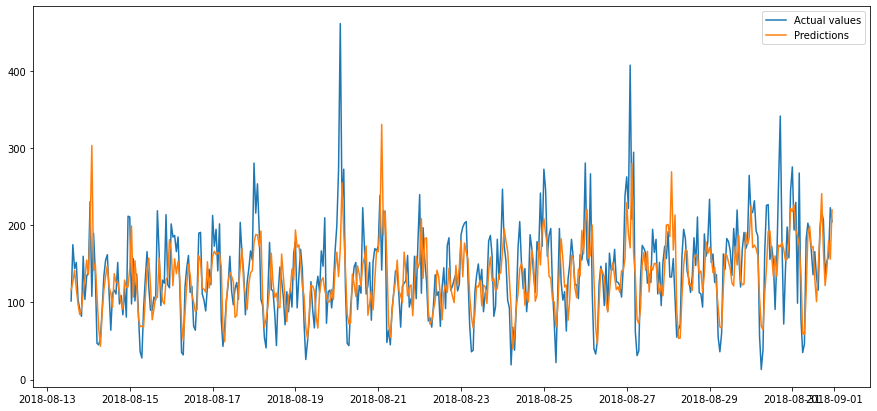

In [19]:
best_predictions = best_lin_reg.predict(X_test)
plt.figure(figsize=(15, 7))
print("RMSE:", rmse(best_predictions, y_test))
plt.plot(X_test.index, y_test, label='Actual values')
plt.plot(X_test.index, best_predictions, label='Predictions')
plt.legend()
plt.show()

RMSE: 47.196002285394556


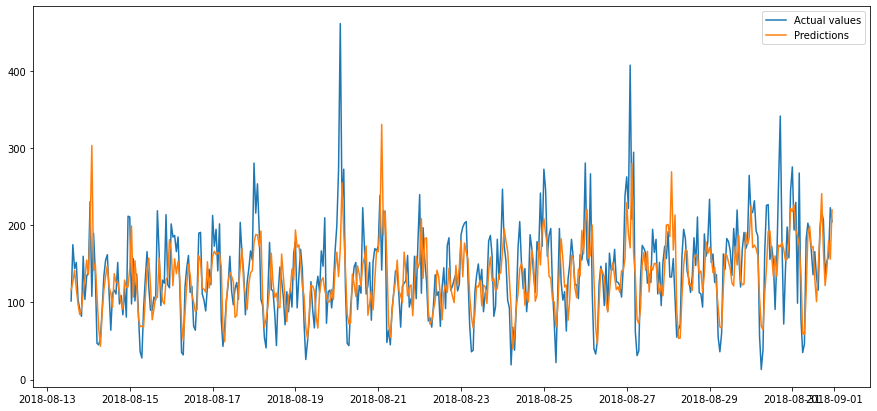

In [20]:
best_predictions_r = best_params_R.predict(X_test)
plt.figure(figsize=(15, 7))
print("RMSE:", rmse(best_predictions_r, y_test))
plt.plot(X_test.index, y_test, label='Actual values')
plt.plot(X_test.index, best_predictions, label='Predictions')
plt.legend()
plt.show()

RMSE: 47.16773075785186


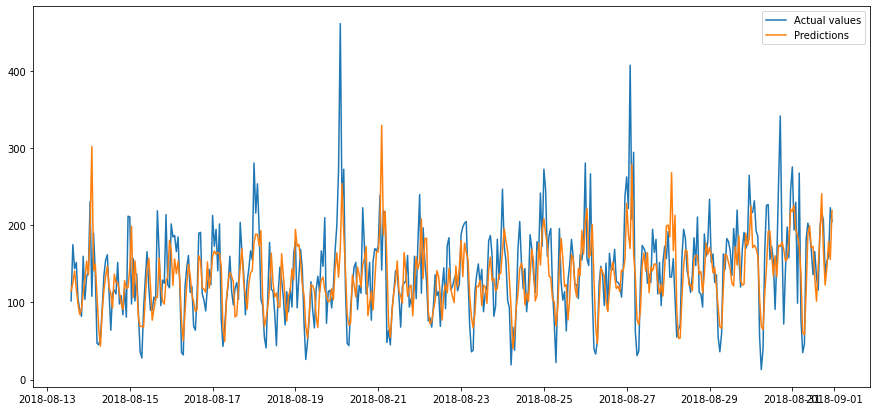

In [21]:
best_predictions = best_lin_lasso.predict(X_test)
plt.figure(figsize=(15, 7))
print("RMSE:", rmse(best_predictions, y_test))
plt.plot(X_test.index, y_test, label='Actual values')
plt.plot(X_test.index, best_predictions, label='Predictions')
plt.legend()
plt.show()

**Вывод**

- Данные ресемплированы
- Рассмотрели следующие модели : LinearRegression, Ridge, Lasso.
- В качестве лучшей выбрана Lasso регрессия
- Достигнутое значение метрики RMSE на тестовой выборке: ~47.16

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48